# Task2

## Load Dataset

In [ ]:
# IMPORTANT:
#   Whenever you start a new colab runtime, use the following code to download
#   the training dataset onto the runtime local storage.
#   This should take ~3-5 mins for the whole dataset.
#   You can then load data from the local storage (/content/data) into your colab
#   notebook using the `h5py` library (see example below).
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="train.h5", repo_type="dataset", local_dir="data")
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="events.csv", repo_type="dataset", local_dir="data")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.h5:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

events.csv:   0%|          | 0.00/782k [00:00<?, ?B/s]

'data/events.csv'

In [ ]:
import pandas as pd
import h5py
import IPython
import PIL
import matplotlib.pyplot as plt
import os
import io
import numpy as np
from PIL import Image

In [ ]:
# this DataFrame contains all of the event meta data
df = pd.read_csv("data/events.csv", parse_dates=["start_utc"])
df

id img_type                 start_utc  llcrnrlat   llcrnrlon  \
0     S778114    ir069 2018-08-20 19:50:00+00:00  32.781533  -92.631841   
1     S778114    ir107 2018-08-20 19:50:00+00:00  32.781533  -92.631841   
2     S778114     lght                       NaT  32.781533  -92.631841   
3     S778114      vil 2018-08-20 19:50:00+00:00  32.781533  -92.631841   
4     S778114      vis 2018-08-20 19:50:00+00:00  32.781533  -92.631841   
...       ...      ...                       ...        ...         ...   
3995  S832818    ir069 2019-07-28 17:44:00+00:00  46.493514 -100.371384   
3996  S832818    ir107 2019-07-28 17:44:00+00:00  46.493514 -100.371384   
3997  S832818     lght                       NaT  46.493514 -100.371384   
3998  S832818      vil 2019-07-28 17:45:00+00:00  46.493514 -100.371384   
3999  S832818      vis 2019-07-28 17:44:00+00:00  46.493514 -100.371384   

      urcrnrlat  urcrnrlon                                               proj  \
0     35.944590 -88.134075  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
1     35.944590 -88.134075  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
2     35.944590 -88.134075  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
3     35.944590 -88.134075  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
4     35.944590 -88.134075  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
...         ...        ...                                                ...   
3995  49.953392 -95.191216  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
3996  49.953392 -95.191216  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
3997  49.953392 -95.191216  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
3998  49.953392 -95.191216  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
3999  49.953392 -95.191216  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   

      height_m   width_m  
0     384000.0  384000.0  
1     384000.0  384000.0  
2     384000.0  384000.0  
3     384000.0  384000.0  
4     384000.0  384000.0  
...        ...       ...  
3995  384000.0  384000.0  
3996  384000.0  384000.0  
3997  384000.0  384000.0  
3998  384000.0  384000.0  
3999  384000.0  384000.0  

[4000 rows x 10 columns]

In [ ]:
print(f"Total number of events: {len(df.id.unique())}")

Total number of events: 800


In [ ]:
# this function loads all of the image arrays for a given id
def load_event(id):
    "Load event"
    with h5py.File(f'data/train.h5','r') as f:
        event = {img_type: f[id][img_type][:] for img_type in ['vis', 'ir069', 'ir107', 'vil', 'lght']}
    return event

event = load_event("S778114")
for img_type in event:
    print(f"{img_type}: {event[img_type].shape} ({event[img_type].dtype})")

vis: (384, 384, 36) (int16)
ir069: (192, 192, 36) (int16)
ir107: (192, 192, 36) (int16)
vil: (384, 384, 36) (uint8)
lght: (38777, 5) (float32)


In [ ]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from livelossplot import PlotLosses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Data Preparation

- The data we need to use in this task include: vis (visible light): 384 × 384 × 36, ir069 (infrared 6.9 μm): 192 × 192 × 36, ir107 (infrared 10.7 μm): 192 × 192 × 36, vil (vertically integrated liquid water) (target value): 384 × 384 × 36.
- Therefore, unifying the image size is a prerequisite. In order to ensure the accuracy of image prediction, we use the upsampling method to unify the image into a 384 × 384 format.

In [ ]:
class StormDataset(Dataset):
    def __init__(self, event_ids, transform=None):
        self.event_ids = event_ids
        self.transform = transform
        self.metadata = pd.read_csv("data/events.csv", parse_dates=["start_utc"])

    def __len__(self):
        return len(self.event_ids)

    def _process_frame(self, event, t):
        vis_min, vis_max = np.min(event['vis']), np.max(event['vis'])
        ir069_min, ir069_max = np.min(event['ir069']), np.max(event['ir069'])
        ir107_min, ir107_max = np.min(event['ir107']), np.max(event['ir107'])

        # Upsample IR channels and normalize to [0, 1]
        vis = torch.tensor(event['vis'][..., t].astype(np.float32))
        vis = (vis - vis_min) / (vis_max - vis_min)
        ir069 = F.interpolate(
            torch.tensor(event['ir069'][..., t].astype(np.float32)).unsqueeze(0).unsqueeze(0),
            size=(384, 384), mode='bilinear'
        ).squeeze()
        ir069 = (ir069 - ir069_min) / (ir069_max - ir069_min)
        ir107 = F.interpolate(
            torch.tensor(event['ir107'][..., t].astype(np.float32)).unsqueeze(0).unsqueeze(0),
            size=(384, 384), mode='bilinear'
        ).squeeze()
        ir107 = (ir107 - ir107_min) / (ir107_max - ir107_min)

        input_img = torch.stack([vis, ir069, ir107], dim=0)
        target = torch.tensor(event['vil'][..., t].astype(np.float32)).unsqueeze(0) / 255.0

        return input_img, target

    def __getitem__(self, idx):
        event_id = self.event_ids[idx]
        with h5py.File('data/train.h5', 'r') as f:
            event = {img_type: f[event_id][img_type][:] for img_type in ['vis', 'ir069', 'ir107', 'vil']}

        inputs, targets = [], []
        for t in range(36):
            if not np.isnan(event['vis'][..., t]).any():
                inp, tgt = self._process_frame(event, t)
                inputs.append(inp)
                targets.append(tgt)

        inputs = torch.stack(inputs)
        targets = torch.stack(targets)

        if self.transform:
            inputs, targets = self.transform(inputs, targets)

        return inputs, targets

## DataLoader

- For the training set and test set, we split them in the form of direct random division according to proportion, and the test set accounted for 20%.
- In this process, considering a larger training dataset can present better model performance, we used all events for training and testing, surprisingly, RAM is not crushing with all event during the process.
- In the end, there were 640 events used as the training data set and 160 events used as the test data set.

In [ ]:
# Split dataset
all_ids = pd.read_csv("data/events.csv")['id'].unique()
train_ids, test_ids = train_test_split(all_ids, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = StormDataset(train_ids)
test_dataset = StormDataset(test_ids)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=2)


In [ ]:
print(f'Size of train dataset: {len(train_dataset)}')
print(f'Size of test dataset: {len(test_dataset)}')

Size of train dataset: 640
Size of test dataset: 160


## Model Architecture

- As for the model, we chose **UNet** as the final prediction model, which mainly includes Encoder (extracting high-level features of the input image), Decoder (recovering spatial information and generating the final prediction result), and Skip Connections (used to transfer information between encoding and decoding to retain more details):

1. The encoder contains four layers of convolution, and also includes a pooling layer to reduce the space size by half, reduce the amount of calculation, and prevent RAM from being crushed.

2. The decoder first uses ConvTranspose2d deconvolution to upsample and restore the spatial size, then uses conv_block for further feature extraction.

3. combines skip connection to allow low-level features to participate in recovery, improve resolution, and achieve more accurate prediction.



In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        '''self.enc1 = self.conv_block(3, 8)
        self.enc2 = self.conv_block(8, 16)
        self.enc3 = self.conv_block(16, 32)
        self.enc4 = self.conv_block(32, 64)
        self.pool = nn.MaxPool2d(2)

        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(64, 32)  # Input: upsampled + skip connection

        self.up3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(32, 16)  # Input: upsampled + skip connection

        self.up2 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(16, 8)  # Input: upsampled + skip connection

        self.dec1 = nn.Conv2d(8, 1, kernel_size=1)'''

        self.enc1 = self.conv_block(3, 16)  # Double of 8
        self.enc2 = self.conv_block(16, 32)  # Double of 16
        self.enc3 = self.conv_block(32, 64)  # Double of 32
        self.enc4 = self.conv_block(64, 128)  # Double of 64
        self.pool = nn.MaxPool2d(2)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Double of 64 to 32
        self.dec4 = self.conv_block(128, 64)  # Double of 64 to 32 (input: upsampled + skip connection)

        self.up3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # Double of 32 to 16
        self.dec3 = self.conv_block(64, 32)  # Double of 32 to 16 (input: upsampled + skip connection)

        self.up2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # Double of 16 to 8
        self.dec2 = self.conv_block(32, 16)  # Double of 16 to 8 (input: upsampled + skip connection)

        self.dec1 = nn.Conv2d(16, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool(e1)
        e2 = self.enc2(p1)
        p2 = self.pool(e2)
        e3 = self.enc3(p2)
        p3 = self.pool(e3)
        e4 = self.enc4(p3)

        # Decoder
        d4 = self.up4(e4)
        d4 = torch.cat([d4, e3], dim=1)  # Concatenate skip connection
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e2], dim=1)  # Concatenate skip connection
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e1], dim=1)  # Concatenate skip connection
        d2 = self.dec2(d2)

        d1 = self.dec1(d2)

        return d1

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

from torchsummary import summary
summary(model, input_size=(3, 384, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 384, 384]             448
       BatchNorm2d-2         [-1, 16, 384, 384]              32
              ReLU-3         [-1, 16, 384, 384]               0
            Conv2d-4         [-1, 16, 384, 384]           2,320
       BatchNorm2d-5         [-1, 16, 384, 384]              32
              ReLU-6         [-1, 16, 384, 384]               0
         MaxPool2d-7         [-1, 16, 192, 192]               0
            Conv2d-8         [-1, 32, 192, 192]           4,640
       BatchNorm2d-9         [-1, 32, 192, 192]              64
             ReLU-10         [-1, 32, 192, 192]               0
           Conv2d-11         [-1, 32, 192, 192]           9,248
      BatchNorm2d-12         [-1, 32, 192, 192]              64
             ReLU-13         [-1, 32, 192, 192]               0
        MaxPool2d-14           [-1, 32,

## Loss Function

- In terms of selecting the loss function, we initially tried various loss functions such as L1, MSE, SSIM+L1+Focal.
- However, the final visualization results showed that the red area in GroundTruth, which should have been red, was not obvious, meaning that *high-amplitude* values ​​were not valued in the expression of the model.
- Therefore, we turn to a customized loss function, **AmplitudeAwareLoss** function, which is an improved L1 loss function.
- The core idea is to give *greater weight* to high-amplitude areas to improve the model's prediction ability in high-amplitude areas.

In [ ]:
class AmplitudeAwareLoss(nn.Module):
    def __init__(self, alpha=2.0, threshold=0.7):
        super().__init__()
        self.alpha = alpha
        self.threshold = threshold

    def forward(self, y_pred, y_true):
        base_loss = F.l1_loss(y_pred, y_true)
        high_value_mask = (y_true > self.threshold).float()
        high_loss = F.l1_loss(y_pred * high_value_mask,
                              y_true * high_value_mask)

        return base_loss + self.alpha * high_loss

In [ ]:
criterion = AmplitudeAwareLoss().to(device)
lossfunc = nn.L1Loss() # this is the loss function for plotting the L1 loss curve
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
liveloss = PlotLosses()

## Training Loop

**For the iterations**
- During the training process, we will calculate the training loss and the test loss, and finally draw the corresponding loss curve.
- Since each round of training takes a long time, only 10 iterations are performed here.

**For the training and testing curves**

1. ***Training curve***
- The training loss dropped from 0.10 to about 0.07, showing a steady downward trend, indicating that the model is constantly learning and optimizing parameters on the training set to reduce the error.
- The training loss is steadily decreasing, indicating that the model has converged well and there is no obvious oscillation or overfitting trend.
- There is no situation where the loss does not decrease or increase, indicating that the model is still learning effectively.

2. ***Testing curve***
- The test loss also showed a downward trend, from 0.09 to about 0.072, but there was a slight fluctuation in the 5th and 6th rounds.
- The overall decline in test loss indicates that the model's generalization ability on the test set has increased, meaning that it not only performs well on the training data, but also can adapt to new data.
- There was an fluctuation around the 6th round of iteration, which may be caused by the high learning rate, resulting in some instability when updating the weights.
- In the end, the model has not yet fully converged and is still adjusting its weights. However, since each epoch takes a really long time to run, 10 iterations can basically meet the prediction effect in this task.


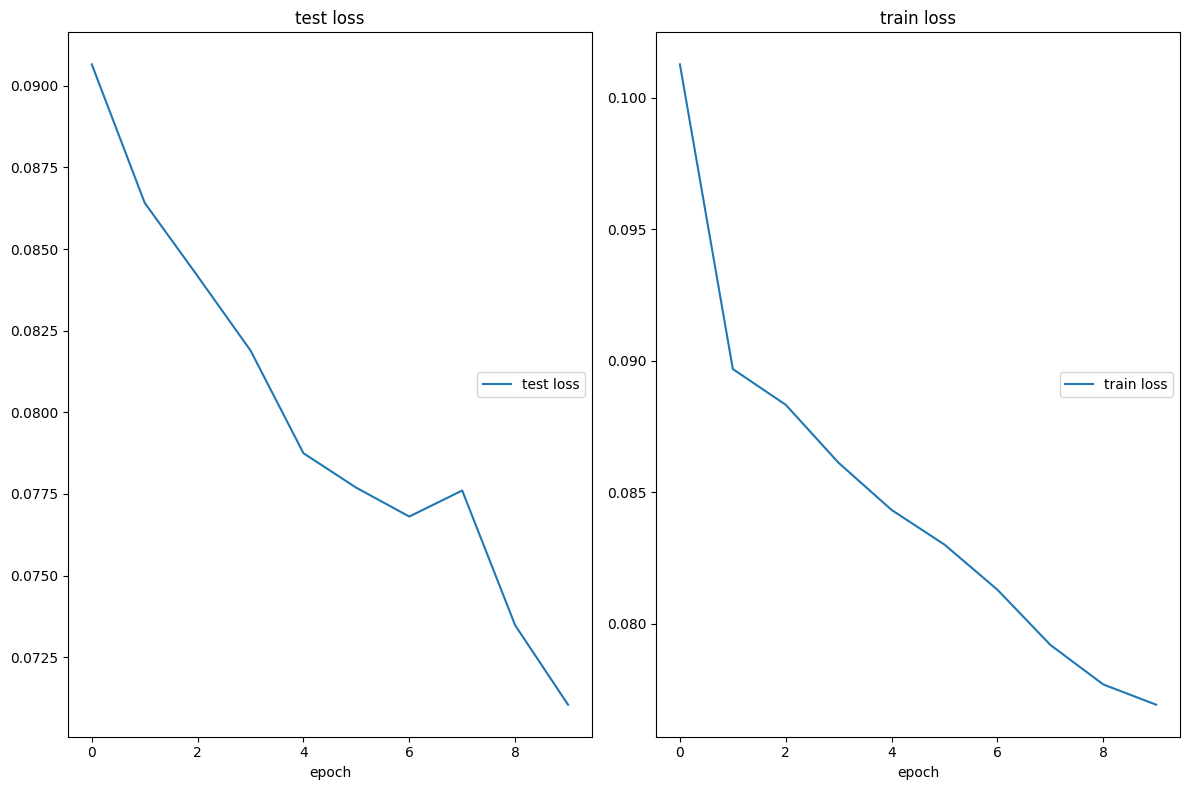

test loss
	test loss        	 (min:    0.071, max:    0.091, cur:    0.071)
train loss
	train loss       	 (min:    0.077, max:    0.101, cur:    0.077)


In [ ]:
for epoch in range(10):
    logs = {}
    model.train()
    train_loss = 0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        '''batch_size, time_steps, channels, height, width = inputs.shape
        random_timesteps = torch.randint(0, time_steps, (batch_size,))
        inputs = torch.stack([inputs[i, t] for i, t in enumerate(random_timesteps)]).to(device)
        targets = torch.stack([targets[i, t] for i, t in enumerate(random_timesteps)]).to(device)'''
        inputs = inputs.view(-1, 3, 384, 384).to(device)
        targets = targets.view(-1, 1, 384, 384).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}: Train Loss: {train_loss / len(train_loader):.4f}")
    logs['train loss'] = train_loss / len(train_loader)
    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            '''batch_size, time_steps, channels, height, width = inputs.shape
            random_timesteps = torch.randint(0, time_steps, (batch_size,))
            inputs = torch.stack([inputs[i, t] for i, t in enumerate(random_timesteps)]).to(device)
            targets = torch.stack([targets[i, t] for i, t in enumerate(random_timesteps)]).to(device)'''
            inputs = inputs.view(-1, 3, 384, 384).to(device)
            targets = targets.view(-1, 1, 384, 384).to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, targets)
            val_loss += test_loss.item()
            lossl1 = lossfunc(outputs, targets)
            l1_loss += lossl1.item()

    print(f"Epoch {epoch+1}: Validation Loss: {val_loss / len(test_loader):.4f}")
    logs['test loss'] = val_loss / len(test_loader)

    liveloss.update(logs)
    liveloss.draw()


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Prediction and Visualization

**Basically, the following code realizes the following functions:**

1. First, load the pre-trained U-Net model and perform VIL prediction for the specified storm event, returning the normalized result.
2. Load the test dataset and convert the input data to a shape that fits the U-Net to perform inference.
3. Post-process the prediction results, including removing negative values ​​and denormalizing to meet visualization requirements.
4. Visualize the VIL prediction results, draw static frames and generate GIFs to facilitate observation of trends over time.
5. Call the visualization function to display the prediction results.
6. Plot the difference map to see the difference between GroundTruth image and predictied image.

Predicted VIL shape: (36, 384, 384)
GIF saved as vil_prediction.gif


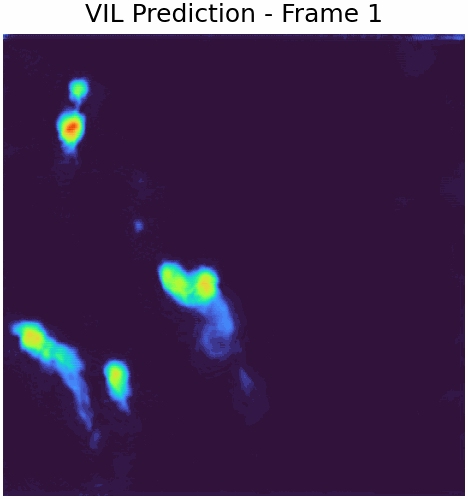

In [ ]:
def predict_vil(event_id):
    # Load model
    #model.load_state_dict(torch.load('/content/gdrive/MyDrive/Project/models/model_11.pth', weights_only=True))
    model.eval()

    # Load and process event
    test_dataset = StormDataset([event_id])
    dataloader = DataLoader(test_dataset, batch_size=2)

    #inputs, targets = test_dataset[0]

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.view(-1, 3, 384, 384).to(device)
            outputs = model(inputs)

    # Convert back to numpy array and clip negative values to zero
    predicted_vil = outputs.squeeze().cpu().numpy()
    predicted_vil[predicted_vil < 0] = 0  # Set negative values to zero
    predicted_vil = (predicted_vil * 255).astype(np.uint8)  # Scale to 0-255

    return predicted_vil

# Example usage
vil_prediction = predict_vil("S778114")
print(f"Predicted VIL shape: {vil_prediction.shape}")

def make_gif(outfile, files, fps=10, loop=0):
    "Helper function for saving GIFs"
    imgs = [PIL.Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='gif', append_images=imgs[1:],
                 save_all=True, duration=int(1000/fps), loop=loop)
    im = IPython.display.Image(filename=outfile)
    im.reload()
    return im

def plot_vil_prediction(vil_prediction, output_gif=False, save_gif=False, gif_name="vil_prediction.gif"):
    "Helper function to plot and save VIL prediction frames as GIF"
    num_frames, height, width = vil_prediction.shape
    def plot_frame(frame_idx):
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(vil_prediction[frame_idx], vmin=0, vmax=255, cmap="turbo")
        ax.set_title(f"VIL Prediction - Frame {frame_idx + 1}")
        ax.axis("off")
        if output_gif:
            file = f"_temp_frame_{frame_idx}.png"
            fig.savefig(file, bbox_inches="tight", dpi=150, pad_inches=0.02, facecolor="white")
            plt.close()
        else:
            plt.show()
    if output_gif:
        for frame_idx in range(num_frames):
            plot_frame(frame_idx)
        im = make_gif(gif_name, [f"_temp_frame_{frame_idx}.png" for frame_idx in range(num_frames)])
        for frame_idx in range(num_frames):
            os.remove(f"_temp_frame_{frame_idx}.png")
        if save_gif:
            print(f"GIF saved as {gif_name}")
        else:
            os.remove(gif_name)
        IPython.display.display(im)
    else:
        plot_frame(0)
        plot_frame(num_frames // 2)
        plot_frame(num_frames - 1)

# Example usage
plot_vil_prediction(vil_prediction, output_gif=True, save_gif=True)

In [ ]:
def plot_difference(vil_prediction, ground_truth, frame_idx=0, output_gif=False, gif_name="difference.gif"):
    """
    Plot and optionally save the difference between ground truth and predictions.

    Args:
        vil_prediction (numpy array): Predicted VIL frames, shape (T, H, W).
        ground_truth (numpy array): Ground truth VIL frames, shape (T, H, W).
        frame_idx (int): Frame index to plot for difference.
        output_gif (bool): Whether to output the difference as a GIF.
        gif_name (str): Name of the GIF file.
    """
    # Compute the absolute difference
    difference = np.abs(vil_prediction - ground_truth)

    # Normalize difference for better visualization
    max_diff = np.max(difference)
    difference_normalized = (difference / max_diff) * 255 if max_diff > 0 else difference

    def plot_frame(frame_idx):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        # Predicted VIL
        axes[0].imshow(vil_prediction[frame_idx], cmap="turbo")
        axes[0].set_title(f"Prediction - Frame {frame_idx + 1}")
        axes[0].axis("off")

        # Ground Truth VIL
        axes[1].imshow(ground_truth[frame_idx], cmap="turbo")
        axes[1].set_title(f"Ground Truth - Frame {frame_idx + 1}")
        axes[1].axis("off")

        # Difference
        axes[2].imshow(difference_normalized[frame_idx], cmap="hot")
        axes[2].set_title(f"Difference - Frame {frame_idx + 1}")
        axes[2].axis("off")

        if output_gif:
            file = f"_temp_diff_frame_{frame_idx}.png"
            fig.savefig(file, bbox_inches="tight", dpi=150, pad_inches=0.02, facecolor="white")
            plt.close()
        else:
            plt.show()

    if output_gif:
        temp_files = []
        for frame_idx in range(difference.shape[0]):
            file = f"_temp_diff_frame_{frame_idx}.png"
            temp_files.append(file)
            plot_frame(frame_idx)
        im = make_gif(gif_name, temp_files, fps=10)
        for file in temp_files:
            os.remove(file)
        print(f"GIF saved as {gif_name}")
    else:
        plot_frame(frame_idx)


def extract_ground_truth_vil(event_id):
    """
    Extract ground truth VIL for a given event ID from the dataset.
    """
    test_dataset = StormDataset([event_id])
    _, ground_truth = test_dataset[0]  # Only need the targets
    return ground_truth.squeeze(1).numpy() * 255  # Shape: (T, H, W), scale to 0-255

**The overall performace is pretty good, comparing the GroundTruth and the prediction images, they are not identical but quite similar. Even we can see there are still some differences between the real and predicted ones according to the difference map, thus the model can be optimized further.**

GIF saved as vil_difference.gif


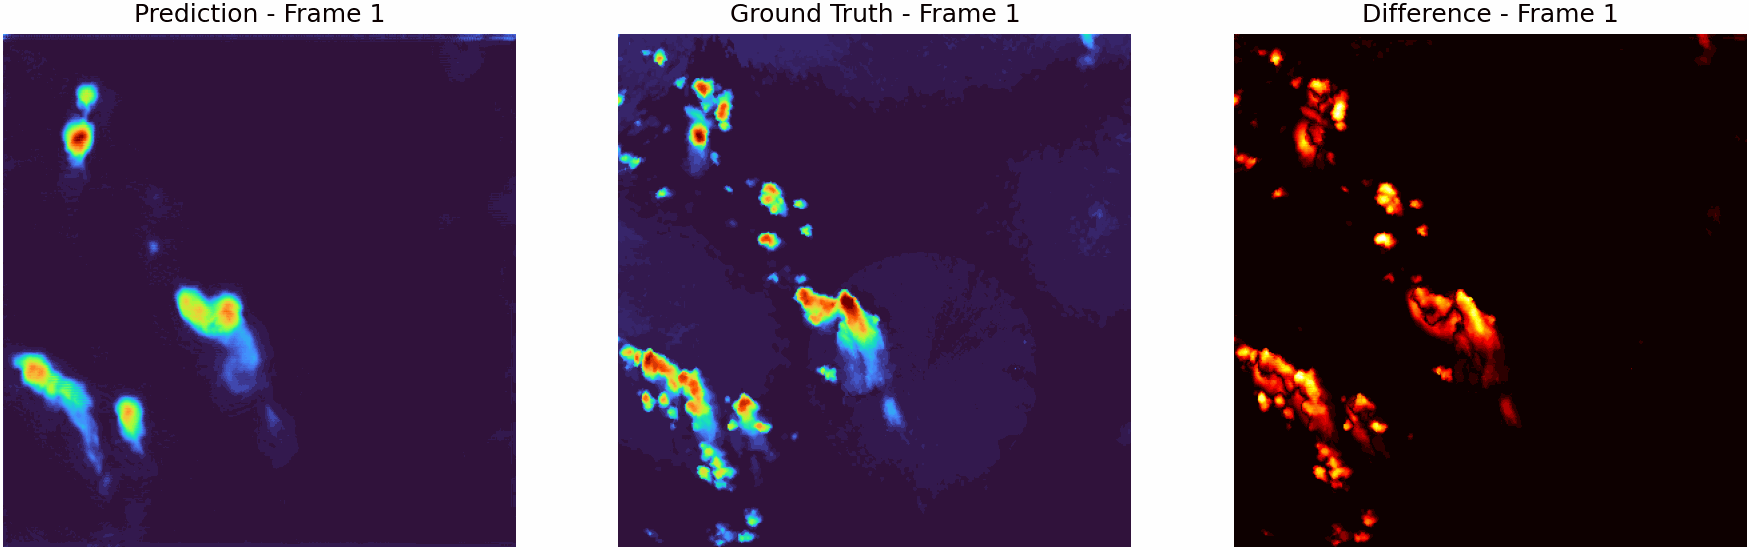

In [ ]:
# Extract ground truth VIL
ground_truth_vil = extract_ground_truth_vil("S778114")

# Visualize the difference
plot_difference(vil_prediction, ground_truth_vil, output_gif=True, gif_name="vil_difference.gif")

from IPython.display import Image, display

# Display the GIF
gif_path = "vil_difference.gif"
display(Image(filename=gif_path))

## Frame-wise L1 error

- The following function implements the function of visualizing L1 loss frame by frame, which can help check the performance of the model in the time dimension.
- The final results show that the L1 error increases with time. In the first few frames, the error is low and relatively stable, indicating that the model is more accurate in the early predictions.
- However, as time goes by (after Frame 10), the error begins to rise slowly and increases significantly in the last few frames.
- This shows that the model accumulates errors when predicting for a long time, and the prediction effect gradually deteriorates.

In [ ]:
def compute_framewise_l1_error(vil_prediction, ground_truth):
    """
    Compute frame-wise L1 error between predicted and ground truth VIL.

    Args:
        vil_prediction (numpy array): Predicted VIL frames, shape (T, H, W).
        ground_truth (numpy array): Ground truth VIL frames, shape (T, H, W).

    Returns:
        numpy array: L1 error for each frame (shape: T).
    """
    l1_errors = np.mean(np.abs(vil_prediction - ground_truth), axis=(1, 2))  # Mean over H, W
    return l1_errors / 255.0


def plot_framewise_errors(l1_errors):
    """
    Plot frame-wise L1 over time.

    Args:
        l1_errors (numpy array): Frame-wise L1 errors.
    """
    frames = np.arange(len(l1_errors))

    plt.figure(figsize=(12, 4))
    plt.plot(frames, l1_errors, label="L1 Loss", marker='o')
    plt.xlabel("Frame Index")
    plt.ylabel("L1 Loss")
    plt.title("Frame-wise L1 Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

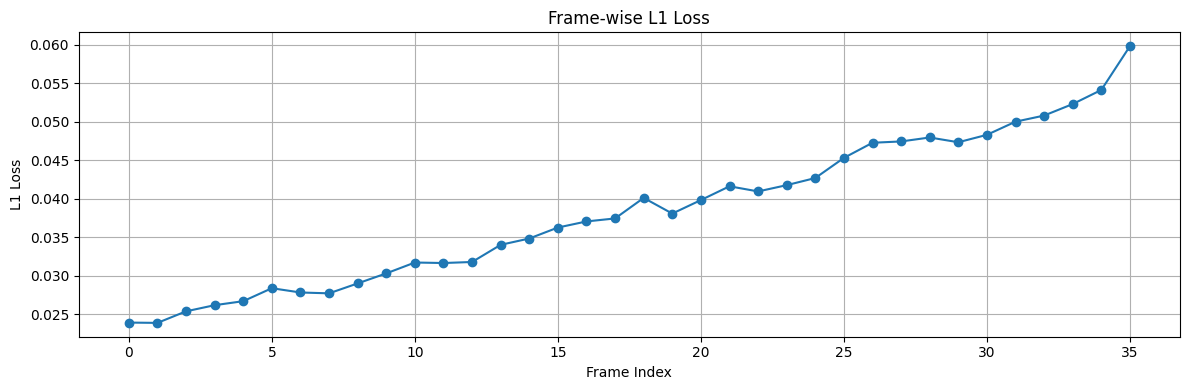

In [ ]:
errors = compute_framewise_l1_error(vil_prediction, ground_truth_vil)
plot_framewise_errors(errors)

# Bonus

## Scaling laws

For bonus part in task2, we try to analyze different performances in different dataset sizes and in different parameters for scaling law part.

### Dataset size

**We divide the model's training data into ten groups ranging from 10% to 100%, and judge the expressiveness of the final model with different data set sizes by observing the final training and test L1 loss curves.**

***For the result:***
- The overall training loss is on a downward trend, but overall it shows a good trend for training.
- As the amount of training data increases, the error of the model on the training set decreases, but it fluctuates between 20% and 60%. This may be due to the small amount of data, which leads to weak generalization ability of the model and unstable loss. When the amount of data increases, it may be due to the quality of the data.
- At 80% of the data, the loss reaches the lowest point, which is the optimal training effect. After that, the loss rises slightly at 100% of the data set. This may be due to the large training set and the unadjusted learning rate, which leads to a decrease in convergence efficiency.

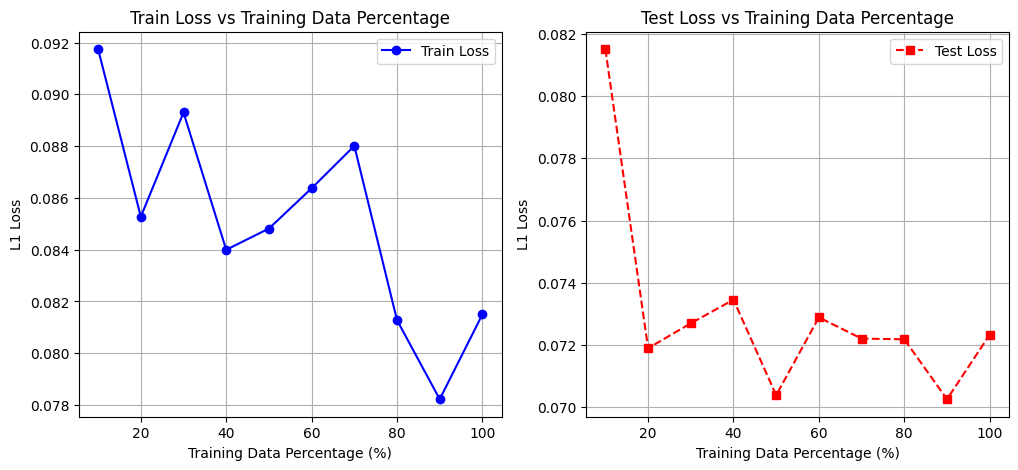

✅ Model 100% saved to /content/gdrive/MyDrive/Tesk2_bonus/model_100.pth


In [ ]:
from livelossplot import PlotLosses
from IPython.display import display, clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_ids = pd.read_csv("data/events.csv")['id'].unique()
train_ids, test_ids = train_test_split(all_ids, test_size=0.2, random_state=42)

percentages = np.arange(0.1, 1.1, 0.1)
train_losses, test_losses = [], []

criterion = torch.nn.L1Loss()

# initialize train and test loss
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
train_line, = ax[0].plot([], [], marker='o', linestyle='-', color='b', label="Train Loss")
test_line, = ax[1].plot([], [], marker='s', linestyle='--', color='r', label="Test Loss")

ax[0].set_xlabel("Training Data Percentage (%)")
ax[0].set_ylabel("L1 Loss")
ax[0].set_title("Train Loss vs Training Data Percentage")
ax[0].grid(True)
ax[0].legend()

ax[1].set_xlabel("Training Data Percentage (%)")
ax[1].set_ylabel("L1 Loss")
ax[1].set_title("Test Loss vs Training Data Percentage")
ax[1].grid(True)
ax[1].legend()

plt.ion()  # update image dynamically
plt.show()

for pct in percentages:
    num_train_samples = int(len(train_ids) * pct)
    subset_train_ids = train_ids[:num_train_samples]

    train_dataset = StormDataset(subset_train_ids)
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)

    if len(train_loader) == 0:
        print(f"Warning: train_loader is empty for {int(pct*100)}% dataset! Skipping...")
        continue

    model = UNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Train the model
    print(f"\n Training on {int(pct*100)}% dataset...")

    total_train_loss = 0  # calculate loss for the whole dataset
    num_train_batches = 0

    for epoch in range(5):
        model.train()
        epoch_loss = 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/5 ({int(pct*100)}%)", leave=True):
            inputs, targets = inputs.view(-1, 3, 384, 384).to(device), targets.view(-1, 1, 384, 384).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            num_train_batches += 1  # calculate batches

        total_train_loss += epoch_loss

    # calculate the average loss for each pct
    avg_train_loss = total_train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    print(f"Finished training {int(pct*100)}% dataset - Avg Train Loss: {avg_train_loss:.4f}")

    # evaluate the model
    test_dataset = StormDataset(test_ids)
    test_loader = DataLoader(test_dataset, batch_size=1, num_workers=2)

    if len(test_loader) == 0:
        print(f"Warning: test_loader is empty! Skipping testing for {int(pct*100)}% dataset.")
        continue

    model.eval()
    total_test_loss = 0
    num_test_batches = 0
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc=f"Testing {int(pct*100)}%", leave=True):
            inputs, targets = inputs.view(-1, 3, 384, 384).to(device), targets.view(-1, 1, 384, 384).to(device)
            outputs = model(inputs)
            total_test_loss += criterion(outputs, targets).item()
            num_test_batches += 1  # calculate batches

    # calculate the average loss for the whole process
    avg_test_loss = total_test_loss / num_test_batches
    test_losses.append(avg_test_loss)
    print(f"Test Loss for {int(pct*100)}% data: {avg_test_loss:.4f}")

    # update the curve
    train_line.set_data(percentages[:len(train_losses)] * 100, train_losses)
    test_line.set_data(percentages[:len(test_losses)] * 100, test_losses)

    ax[0].relim()
    ax[0].autoscale_view()

    ax[1].relim()
    ax[1].autoscale_view()

    clear_output(wait=True)
    display(fig)

    # save model
    model_path = f"/content/gdrive/MyDrive/Tesk2_bonus/model_{int(pct*100)}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"✅ Model {int(pct*100)}% saved to {model_path}")

plt.ioff()
plt.show()


### Parameters

To see the impact that paramaters can give to prediction, we changed the channels of UNet model, analysing the result based on training and testing L1 loss curve. To speed up our process in bonus, we are not using the whole dataset as training and testing dataset, instead, we use 20% of the whole event to proceed.

#### Channels: 3-8-16-32-64

**For the very first try, we half the channels we use in the Task2 model, therefore we have far less parameters comparing to the one when we train the original model.**
1. ***Training curve***
- There were slight fluctuations in the 1st and 2nd rounds, which may be caused by abnormal learning rate leading to unstable updates.
- The overall decline shows that the model is learning and effectively optimizing parameters, and there is no obvious vibration, indicating that the training process is stable.
- If training continues, the learning rate may be reduced to ensure convergence, or a longer training period may be required to finally observe the performance.
2. ***Testing curve***
- The initial increase in loss may be due to the model not being stable, the learning rate being too large, or the weights being adjusted too quickly.
- The subsequent decrease in loss indicates that the model's generalization ability is improving and it can better predict the test set data.
- The loss fluctuated slightly in the last 1-2 rounds, which may be due to the small or difficult test set data, resulting in large errors in some samples, or the learning rate adjustment may not be smooth enough.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

from torchsummary import summary
summary(model, input_size=(3, 384, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 384, 384]             224
       BatchNorm2d-2          [-1, 8, 384, 384]              16
              ReLU-3          [-1, 8, 384, 384]               0
            Conv2d-4          [-1, 8, 384, 384]             584
       BatchNorm2d-5          [-1, 8, 384, 384]              16
              ReLU-6          [-1, 8, 384, 384]               0
         MaxPool2d-7          [-1, 8, 192, 192]               0
            Conv2d-8         [-1, 16, 192, 192]           1,168
       BatchNorm2d-9         [-1, 16, 192, 192]              32
             ReLU-10         [-1, 16, 192, 192]               0
           Conv2d-11         [-1, 16, 192, 192]           2,320
      BatchNorm2d-12         [-1, 16, 192, 192]              32
             ReLU-13         [-1, 16, 192, 192]               0
        MaxPool2d-14           [-1, 16,

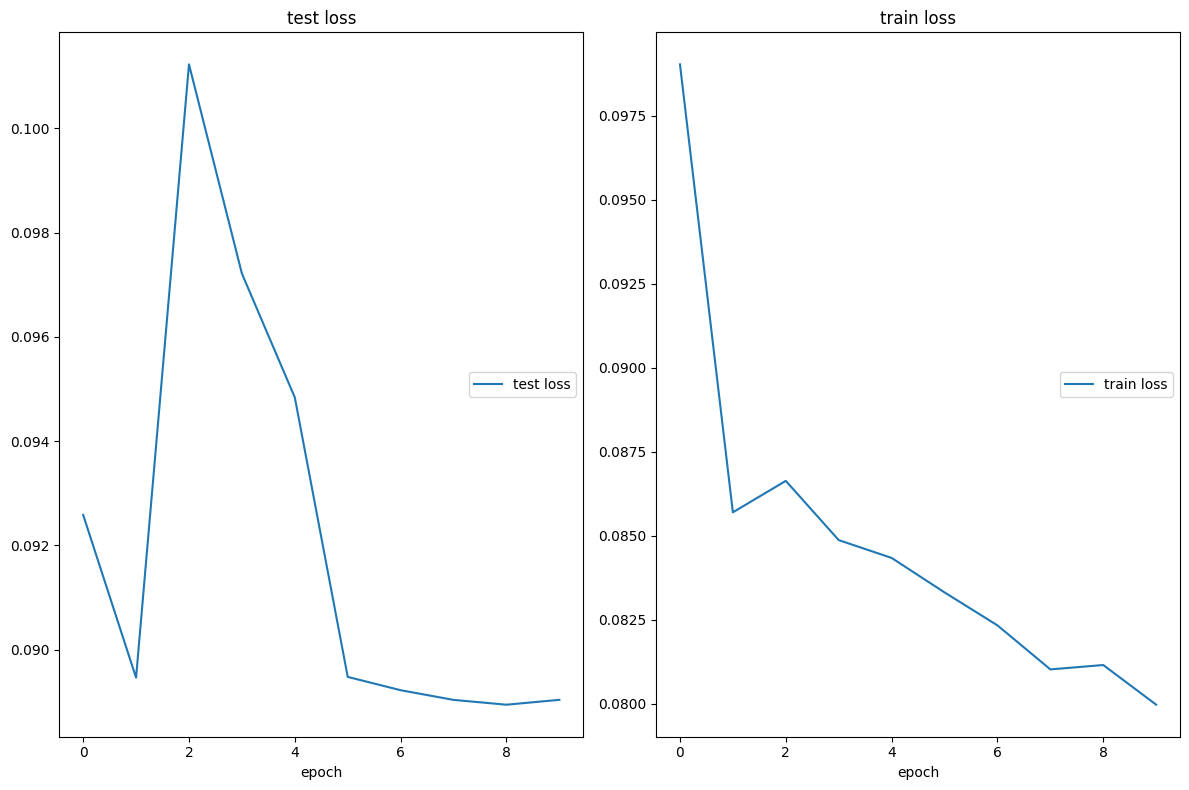

test loss
	test loss        	 (min:    0.089, max:    0.101, cur:    0.089)
train loss
	train loss       	 (min:    0.080, max:    0.099, cur:    0.080)


In [ ]:
# --------------------
# Training Loop
# --------------------

for epoch in range(10):
    logs = {}
    model.train()
    train_loss = 0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        '''batch_size, time_steps, channels, height, width = inputs.shape
        random_timesteps = torch.randint(0, time_steps, (batch_size,))
        inputs = torch.stack([inputs[i, t] for i, t in enumerate(random_timesteps)]).to(device)
        targets = torch.stack([targets[i, t] for i, t in enumerate(random_timesteps)]).to(device)'''
        inputs = inputs.view(-1, 3, 384, 384).to(device)
        targets = targets.view(-1, 1, 384, 384).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}: Train Loss: {train_loss / len(train_loader):.4f}")
    logs['train loss'] = train_loss / len(train_loader)
    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            '''batch_size, time_steps, channels, height, width = inputs.shape
            random_timesteps = torch.randint(0, time_steps, (batch_size,))
            inputs = torch.stack([inputs[i, t] for i, t in enumerate(random_timesteps)]).to(device)
            targets = torch.stack([targets[i, t] for i, t in enumerate(random_timesteps)]).to(device)'''
            inputs = inputs.view(-1, 3, 384, 384).to(device)
            targets = targets.view(-1, 1, 384, 384).to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, targets)
            val_loss += test_loss.item()

    print(f"Epoch {epoch+1}: Validation Loss: {val_loss / len(test_loader):.4f}")
    logs['test loss'] = val_loss / len(test_loader)

    liveloss.update(logs)
    liveloss.draw()


#### Channels: 3-16-32-64-128

For this one, we have the same channels as the final model.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

from torchsummary import summary
summary(model, input_size=(3, 384, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 384, 384]             448
       BatchNorm2d-2         [-1, 16, 384, 384]              32
              ReLU-3         [-1, 16, 384, 384]               0
            Conv2d-4         [-1, 16, 384, 384]           2,320
       BatchNorm2d-5         [-1, 16, 384, 384]              32
              ReLU-6         [-1, 16, 384, 384]               0
         MaxPool2d-7         [-1, 16, 192, 192]               0
            Conv2d-8         [-1, 32, 192, 192]           4,640
       BatchNorm2d-9         [-1, 32, 192, 192]              64
             ReLU-10         [-1, 32, 192, 192]               0
           Conv2d-11         [-1, 32, 192, 192]           9,248
      BatchNorm2d-12         [-1, 32, 192, 192]              64
             ReLU-13         [-1, 32, 192, 192]               0
        MaxPool2d-14           [-1, 32,

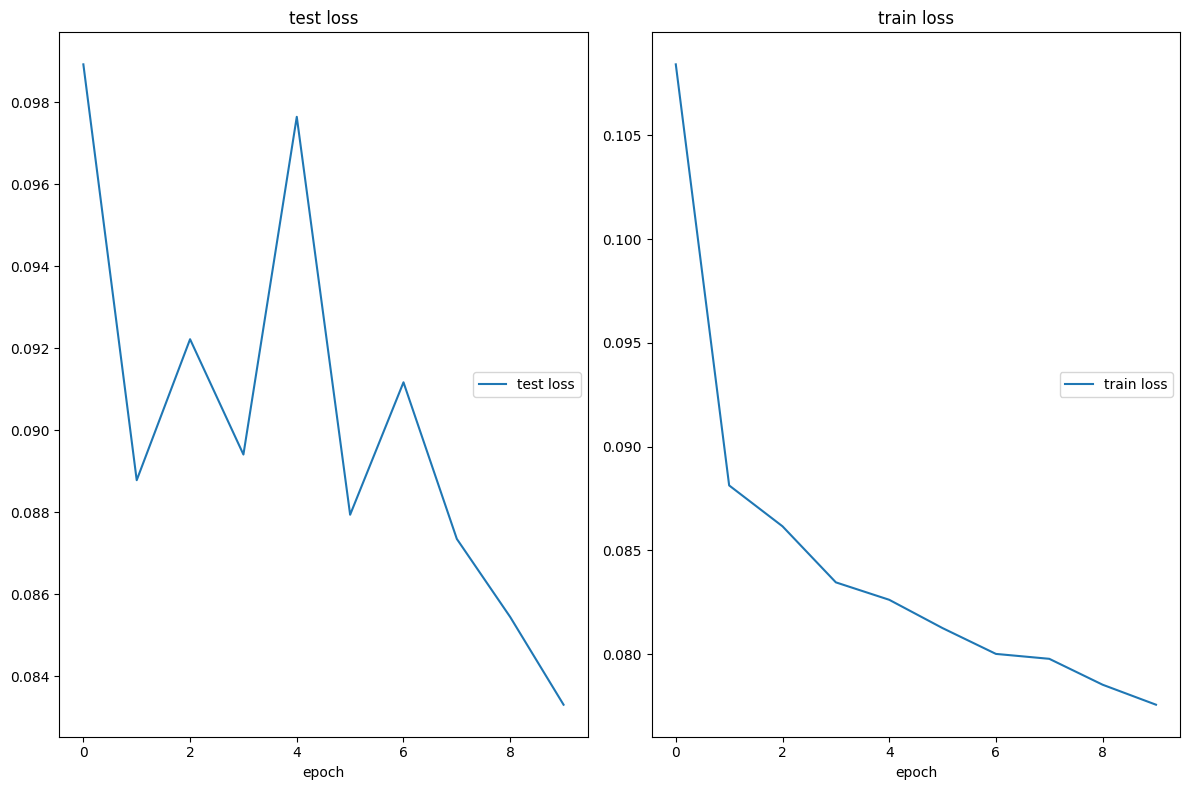

test loss
	test loss        	 (min:    0.083, max:    0.099, cur:    0.083)
train loss
	train loss       	 (min:    0.078, max:    0.108, cur:    0.078)


In [ ]:
for epoch in range(10):
    logs = {}
    model.train()
    train_loss = 0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        '''batch_size, time_steps, channels, height, width = inputs.shape
        random_timesteps = torch.randint(0, time_steps, (batch_size,))
        inputs = torch.stack([inputs[i, t] for i, t in enumerate(random_timesteps)]).to(device)
        targets = torch.stack([targets[i, t] for i, t in enumerate(random_timesteps)]).to(device)'''
        inputs = inputs.view（72，3，384， 384）.to(device)
        targets = targets.view(72, 384, 384).unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}: Train Loss: {train_loss / len(train_loader):.4f}")
    logs['train loss'] = train_loss / len(train_loader)
    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            '''batch_size, time_steps, channels, height, width = inputs.shape
            random_timesteps = torch.randint(0, time_steps, (batch_size,))
            inputs = torch.stack([inputs[i, t] for i, t in enumerate(random_timesteps)]).to(device)
            targets = torch.stack([targets[i, t] for i, t in enumerate(random_timesteps)]).to(device)'''
            inputs = inputs.view（72，3，384， 384）.to(device)
            targets = targets.view(72, 384, 384).unsqueeze(1).to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, targets)
            val_loss += test_loss.item()

    print(f"Epoch {epoch+1}: Validation Loss: {val_loss / len(test_loader):.4f}")
    logs['test loss'] = val_loss / len(test_loader)

    liveloss.update(logs)
    liveloss.draw()


**Reducing the number of channels will seriously affect the expressiveness of the final model. Of course, increasing the number of channels is also an option, but when applying the entire data set, if the number of channels is expanded to twice the parameters of the original channels, RAM will be crushed. Therefore, no experiment will be conducted here. Even if an attempt is made, using the entire data set in actual training will have no reference value.**

## Explaination

***Model***
1. Basically, this model is based on the **U-Net structure**, and the **Encoder-Decoder** in the model can extract multi-scale features, using **Skip Connections** to preserve spatial information, making it suitable for this vil prediction tasks.

2. U-Net encoder consists of **four layers of convolutional blocks**, which gradually reduce the spatial resolution through **MaxPooling** and extract high-level features. And decoder uses **transpose convolution** for upsampling and combines jump connections to restore the original resolution while fusing fine-grained local information.

3. **AmplitudeAwareLoss** improves the model's prediction ability in extreme weather events by giving higher weights to high-storm areas, ensuring the final outcome will be more identical to the GroundTruth image.

***Performance***
1. During the training process, **the model's training loss and test loss both showed a downward trend**, indicating that the model effectively learned the patterns in the data and had no obvious overfitting problems.

2. **The final prediction results performed well**. The model successfully learned the ability to infer `vil` from the `vis`, `ir069`, `ir107` channels and generated a reasonable storm intensity prediction image.

10. **This model demonstrates the potential of deep learning in storm prediction**. By combining more physical information, like radar reflectivity and wind speed and optimizing training strategies, the prediction accuracy and model stability can be further improved in the future.